In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons
!pip install toolz scikit-allel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


## Setup

In [4]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0


## Hardware Config

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on GPU
N_REPLICAS: 1


## Prepare the data

In [6]:
root_dir = '[data_path]'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.full.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.full.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=None)
info = genotypes.iloc[:-1, :9]
genotypes = genotypes.iloc[:-1, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,1|1,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [7]:
ped_file = root_dir+'integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [8]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [9]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [10]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 572)

In [11]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 572)

## MAF

In [12]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

In [13]:
def maf_mapper(txt):
  af = min(list(map(lambda x: float(x), txt.split(";")[1].split("=")[1].split(","))))
  return min(af, 1-af)

In [14]:
mafs = info.iloc[:, 7:8].applymap(maf_mapper)
mafs

,INFO
0,0.024960
1,0.005791
2,0.037141
3,0.000399
4,0.000399
...,...
567,0.000799
568,0.000599
569,0.023562
570,0.000200


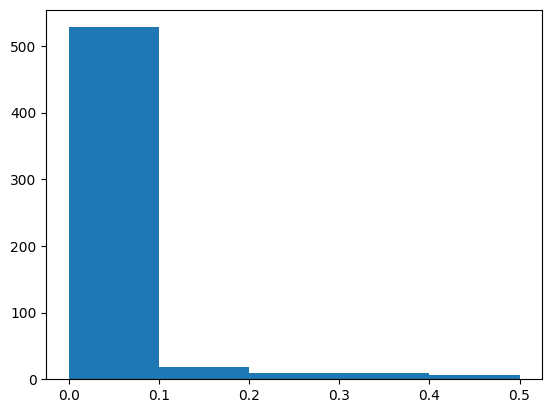

In [15]:
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5]);

In [16]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=False)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([528,  18,  10,  10,   6]))

In [17]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 5
# optimizer learning rate
learning_rate = 0.001
epochs = 60
#epochs = 100   # chr20 LOS 5K


# training batch size
#batch_size = 32   # u19, 4984 samples
bs = 32


lr = 1e-3



# l1 regulalization
kr = 1e-6
k_initial = 'glorot_uniform'


# channel = inChannel
channel = inChannel

ndf_num = 128
kernel_len = 32
num_latent = ndf_num*4
p_size = 2



#dr_rate = drop_prec
dr_rate = 0.2  # avoid overfitting for missing ratio of 0.7

## Model

In [18]:
# AE model in one cell
# # V1: verify our own ae model with yeast genotype data

# # 2.2.8 build variatial autoencoder for snp with subclassing function.

class SNP_ENCODER(tf.keras.Model):
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):
        super(SNP_ENCODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        # object, can be saved in tf mode
        self.stride=1
        self.kl = kernel_len


    def build(self, inputs):
        #encoder
        # dense layer 1
        self.c1 = layers.Conv1D(filters=self.ndf, kernel_size=self.kl, strides=self.stride, padding="same",
                      activation='relu', use_bias=True,
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr),
                      input_shape=(self.feature_size, self.channel))
        self.p1 = layers.MaxPooling1D(pool_size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)

        # dense layer 2
        self.c2 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same",
                      activation='relu', use_bias=True, kernel_initializer=k_initial,
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p2 = layers.MaxPooling1D(pool_size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)

        # dense layer 3
        self.c3 = layers.Conv1D(filters=(4*self.ndf), kernel_size=self.kl, strides=1, padding="same",
                      activation='relu', use_bias=True, kernel_initializer=k_initial,
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p3 = layers.MaxPooling1D(pool_size=p_size)
        self.drop3 = layers.Dropout(rate=self.dr)

        super(SNP_ENCODER, self).build(inputs)

    def call(self, inputs, training=True):
        #print('SNP_ENCODER training flag: ', training)
        x = self.c1(inputs)
        x = self.p1(x)
        x = self.drop1(x, training=training)

        x = self.c2(x)
        x = self.p2(x)
        x = self.drop2(x, training=training)

        x = self.c3(x)
        return x

    # AFAIK: The most convenient method to print model.summary()
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))



# SNP_DECODER(keras.Model):
class SNP_DECODER(tf.keras.Model):
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):
        super(SNP_DECODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        # object, can be saved in tf mode
        self.stride=1
        self.kl=kernel_len

    def build(self, inputs):
        #decoder
        self.c1 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same",
                      activation='relu', use_bias=True,
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr),
                      input_shape=((self.feature_size>>2), self.n_latent))


        self.s1 = layers.UpSampling1D(size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)

        # dense layer 2
        self.c2 = layers.Conv1D(filters=(1*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same",
                      activation='relu', use_bias=True,
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr))

        self.s2 = layers.UpSampling1D(size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)


        # dense layer6
        self.c3 = layers.Conv1D(filters=self.channel, kernel_size=self.kl, strides=1, padding="same",
                      activation='softmax', use_bias=True)

        super(SNP_DECODER, self).build(inputs)

    def call(self, inputs, training = True):
        #print('SNP_DECODER training flag: ', training)
        x = self.c1(inputs)
        x = self.s1(x)
        x = self.drop1(x, training=training)

        x = self.c2(x)
        x = self.s2(x)
        x = self.drop2(x, training=training)


        d_out = self.c3(x)
        return d_out

    # AFAIK: The most convenient method to print model.summary()
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size>>2, self.n_latent))

        return tf.keras.Model(inputs=[x], outputs=self.call(x))



#class SNP_AE(keras.Model):
class SNP_AE(tf.keras.Model):
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):
        super(SNP_AE, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        self.encoder = SNP_ENCODER(self.feature_size)
        self.decoder = SNP_DECODER(self.feature_size)


    def call(self, x, training=True):
        latent = self.encoder(x, training)
        res = self.decoder(latent, training)

        return res, latent

    # AFAIK: The most convenient method to print model.summary()
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [19]:
# plot snp vae encoder model

SNP_encoder = SNP_ENCODER(feature_size)
SNP_encoder.build((None, feature_size, channel))
SNP_encoder.build_graph().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 572, 5)]          0         
                                                                 
 conv1d (Conv1D)             (None, 572, 128)          20608     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 286, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 286, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 256)          1048832   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 143, 256)         0         
 1D)                                                         

In [20]:
# plot snp vae decoder model

SNP_decoder = SNP_DECODER(feature_size)

SNP_decoder.build((None, feature_size>>2, num_latent))
SNP_decoder.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 143, 512)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 143, 256)          4194560   
                                                                 
 up_sampling1d (UpSampling1D  (None, 286, 256)         0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 286, 256)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 286, 128)          1048704   
                                                                 
 up_sampling1d_1 (UpSampling  (None, 572, 128)         0         
 1D)                                                       

In [21]:
# plot snp vae model

SNP_ae = SNP_AE(feature_size)
SNP_ae.build((None, feature_size, channel))
SNP_ae.build_graph().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 572, 5)]          0         
                                                                 
 snp_encoder_1 (SNP_ENCODER)  (None, 143, 512)         5264256   
                                                                 
 snp_decoder_1 (SNP_DECODER)  (None, 572, 5)           5263749   
                                                                 
Total params: 10,528,005
Trainable params: 10,528,005
Non-trainable params: 0
_________________________________________________________________


In [22]:
# AE model sub-functions

def generate_fake_missing(x_in, missing_ratio=0.5):

        # Generates missing genotypes
        # different missing loci for each individuals
        x_fake = x_in.copy()   # with .copy() to not overwrite the original data

        for i in range(x_in.shape[0]):
            missing_size = int(missing_ratio * x_in.shape[1])

            # without repeat random numbers: set replace with false
            missing_index = np.random.choice(x_in.shape[1], size=missing_size, replace=False)

            # missing loci are encoded as [0, 0]
            # x_fake[i, missing_index, :] = [0, 0, 1]  # yeast
            x_fake[i, missing_index, :] = [0, 0, 0, 0, 1]  # human

        return x_fake
        #return x_fake, x_in



def loss_function_cce(recon_x, x):
    # orders: y_true, y_pred
    cce = tf.keras.losses.categorical_crossentropy(x, recon_x)

    #cce = np.double(cce)
    cce = K.cast(cce, dtype='float32')

    lamb1 = 1.0
    loss = lamb1*cce
    #print('loss:', loss)

    loss = tf.reduce_mean(loss)
    #print('ave loss:', loss)

    return loss


## Training

In [23]:
save_dir = "save_path"

if not os.path.exists(save_dir):
  # shutil.rmtree(save_dir)
  os.makedirs(save_dir)

In [24]:
# With constraint
N_SPLITS=3
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = tf.keras.utils.to_categorical(X[X.index.isin(Y_train.index)].to_numpy(), inChannel)
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  accuracies = []
  print(f"Training using fold {fold}")
  print("*******************************************")
  print("*******************************************")

  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True,
                                      stratify=y_train)


  for missing_ratio in [
                        0.05,
                        0.1,
                        0.2
                        ]:
    train_X = np.copy(x_train)
    valid_X = np.copy(x_valid)
    print(f"Missing rate {missing_ratio}")
    print("=====================================================")
    train_X_fake = generate_fake_missing(train_X, missing_ratio)

    diff = np.absolute(np.array(train_X) - np.array(train_X_fake))
    print('train_X_fake diff:', np.sum(diff))


    valid_X_fake = generate_fake_missing(valid_X, missing_ratio)
    diff = np.absolute(np.array(valid_X) - np.array(valid_X_fake))
    print('valid_X_fake diff:', np.sum(diff))


    K.clear_session()
    with strategy.scope():
      model = SNP_AE(feature_size)
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

      train_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
      val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()

      train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
      val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

      for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        #----shuffle train data and lablel for each epoch-----------------------------------------------------------------------------------#
        # shuffle data and labels at the same time
        idx = train_X.shape[0]


        indices = tf.range(start=0, limit=idx, dtype=tf.int32)

        shuffled_indices = tf.random.shuffle(indices)

        train_X_fake = tf.gather(train_X_fake, shuffled_indices)
        train_X = tf.gather(train_X, shuffled_indices)

        snp_x = tf.data.Dataset.from_tensor_slices(train_X_fake).batch(bs, drop_remainder=True)
        snp_y = tf.data.Dataset.from_tensor_slices(train_X).batch(bs, drop_remainder=True)

        snp_x_v = tf.data.Dataset.from_tensor_slices(valid_X_fake).batch(bs, drop_remainder=True)
        snp_y_v = tf.data.Dataset.from_tensor_slices(valid_X).batch(bs, drop_remainder=True)

        loss_batch = []

        # Iterate over the batches of the dataset.
        for step, (snp_fake_batch, snp_label_batch) in enumerate(zip(snp_x, snp_y)):
          with tf.GradientTape() as tape:
              recon_inputs, latents= model(snp_fake_batch, training=True)
              loss = loss_function_cce(recon_inputs, snp_label_batch)


          grads = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))

          loss_batch.append(loss.numpy())


          # Update training metric.
          train_acc_metric.update_state(snp_label_batch, recon_inputs)
          train_loss_metric.update_state(snp_label_batch, recon_inputs)


        # Display metrics at the end of each epoch.
        train_loss = train_loss_metric.result()
        print("Training loss over epoch: ", epoch, train_loss.numpy())

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: ", epoch, train_acc.numpy())


        # Reset training metrics at the end of each epoch
        train_loss_metric.reset_states()
        train_acc_metric.reset_states()


        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in zip(snp_x_v, snp_y_v):

            val_recons, latents = model(x_batch_val, training=False)
            # Update val metrics
            val_loss_metric.update_state(y_batch_val, val_recons)
            val_acc_metric.update_state(y_batch_val, val_recons)

        val_loss = val_loss_metric.result()
        val_acc = val_acc_metric.result()

        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: ", epoch, val_loss.numpy())
        print("Validation acc: ", epoch, val_acc.numpy())


        #print('epoch %s: batch loss = %s' % (epoch, loss_batch))
        loss_epoch = np.mean(loss_batch)
        print('epoch %s: loss = %s' % (epoch, loss_epoch))

    save_name = save_dir + f"preds_mixed_mr_{missing_ratio}_fold_{fold}_probs"
    avg_accuracy = []
    preds = []
    true_labels = []

    to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1], inChannel-1), dtype='float32')
    test_X_missing = np.copy(test_dataset[0])
    for i in tqdm(list(range(test_dataset[0].shape[0]))):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_ratio,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i:i+1, missing_index, :] = [0, 0, 0, 0, 1]
      # predict
      predict_onehot, _ = model(test_X_missing[i:i+1, :, :], training=False)
      predict_onehot = predict_onehot.numpy()
      # only care the missing position
      predict_missing_onehot = predict_onehot[0:1, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)

      preds.extend(predict_missing.ravel().tolist())

      # predict_haplotypes = np.argmax(predict_onehot, axis=2)
      # Only for haploids
      to_save_array[i] = predict_onehot[:, :, :-1]
      # real label
      label_missing_onehot = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      label_missing = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing, label_missing)
      accuracy = np.mean(correct_prediction)

      avg_accuracy.append(accuracy)

    # df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    # df.to_csv(save_name)
    np.save(save_name, to_save_array)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_ratio, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))



Training using fold 1
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84112.0
valid_X_fake diff: 9352.0
Start of epoch 0


Training loss over epoch:  0 0.95916414
Training acc over epoch:  0 0.86214346
Validation loss:  0 0.23652948
Validation acc:  0 0.9578562
epoch 0: loss = 0.9591639
Start of epoch 1
Training loss over epoch:  1 0.2254466
Training acc over epoch:  1 0.9582961
Validation loss:  1 0.21613528
Validation acc:  1 0.9578562
epoch 1: loss = 0.2254466
Start of epoch 2
Training loss over epoch:  2 0.2132088
Training acc over epoch:  2 0.95827
Validation loss:  2 0.20903525
Validation acc:  2 0.9578562
epoch 2: loss = 0.21320878
Start of epoch 3
Training loss over epoch:  3 0.20840837
Training acc over epoch:  3 0.9583472
Validation loss:  3 0.20566398
Validation acc:  3 0.9578562
epoch 3: loss = 0.20840834
Start of epoch 4
Training loss over epoch:  4 0.20303015
Training acc over epoch:  4 0.95827234
Validation loss:  4 0.1944666
Validation acc:  4 0.9578562
epoch 4: loss = 0.20303012
Start of epoch 5
Training loss over epoch:  5 0.19201201
Training acc over epoch:  5 0.95828897
Validation loss:

100%|██████████| 835/835 [00:22<00:00, 37.02it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9639: 
Sensitivity: 0.38520768346167844
Specificity: 0.8118580212683558
F1-score macro: 0.4423259067088037
F1-score micro: 0.9639007698887938
Missing rate 0.1
train_X_fake diff: 171228.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 1.0488324
Training acc over epoch:  0 0.93651307
Validation loss:  0 0.25589588
Validation acc:  0 0.9578562
epoch 0: loss = 1.0488323
Start of epoch 1
Training loss over epoch:  1 0.24748233
Training acc over epoch:  1 0.9582997
Validation loss:  1 0.22890557
Validation acc:  1 0.9578562
epoch 1: loss = 0.24748234
Start of epoch 2
Training loss over epoch:  2 0.22646806
Training acc over epoch:  2 0.9582807
Validation loss:  2 0.21208088
Validation acc:  2 0.9578562
epoch 2: loss = 0.22646807
Start of epoch 3
Training loss over epoch:  3 0.21001935
Training acc over epoch:  3 0.95827234
Validation loss:  3 0.19926165
Validation acc:  3 0.9578562
epoch 3:

100%|██████████| 835/835 [00:21<00:00, 38.54it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9656: 
Sensitivity: 0.3497025595004156
Specificity: 0.7837061889672639
F1-score macro: 0.39926468410716764
F1-score micro: 0.9655636096228596
Missing rate 0.2
train_X_fake diff: 342456.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 1.1404835
Training acc over epoch:  0 0.9177039
Validation loss:  0 0.24131435
Validation acc:  0 0.9578562
epoch 0: loss = 1.1404835
Start of epoch 1
Training loss over epoch:  1 0.23824416
Training acc over epoch:  1 0.9582225
Validation loss:  1 0.23152615
Validation acc:  1 0.9578562
epoch 1: loss = 0.23824412
Start of epoch 2
Training loss over epoch:  2 0.22419709
Training acc over epoch:  2 0.95828897
Validation loss:  2 0.21935976
Validation acc:  2 0.9578562
epoch 2: loss = 0.22419707
Start of epoch 3
Training loss over epoch:  3 0.21851319
Training acc over epoch:  3 0.9582605
Validation loss:  3 0.21791863
Validation acc:  3 0.9578562
epoch 3: l

100%|██████████| 835/835 [00:21<00:00, 38.63it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9595: 
Sensitivity: 0.3233756578284923
Specificity: 0.7815167378630512
F1-score macro: 0.3588661141061724
F1-score micro: 0.9595020485345099
Training using fold 2
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84112.0
valid_X_fake diff: 9352.0
Start of epoch 0
Training loss over epoch:  0 0.7874472
Training acc over epoch:  0 0.93615675
Validation loss:  0 0.24416026
Validation acc:  0 0.95787805
epoch 0: loss = 0.7874472
Start of epoch 1
Training loss over epoch:  1 0.23394652
Training acc over epoch:  1 0.95797783
Validation loss:  1 0.21524185
Validation acc:  1 0.95787805
epoch 1: loss = 0.23394649
Start of epoch 2
Training loss over epoch:  2 0.2112519
Training acc over epoch:  2 0.95799327
Validation loss:  2 0.20212477
Validation acc:  2 0.95787805
epoch 2: loss = 0.21125188
Start of epoch 3
Training loss over epoch:  3 0.19875

100%|██████████| 835/835 [00:22<00:00, 37.24it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9648: 
Sensitivity: 0.3756381331798436
Specificity: 0.803527629039605
F1-score macro: 0.41933098788417966
F1-score micro: 0.9647562018819504
Missing rate 0.1
train_X_fake diff: 171228.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 1.0741166
Training acc over epoch:  0 0.8773516
Validation loss:  0 0.25141227
Validation acc:  0 0.95787805
epoch 0: loss = 1.0741167
Start of epoch 1
Training loss over epoch:  1 0.23282301
Training acc over epoch:  1 0.9579992
Validation loss:  1 0.21663217
Validation acc:  1 0.95787805
epoch 1: loss = 0.23282301
Start of epoch 2
Training loss over epoch:  2 0.21623775
Training acc over epoch:  2 0.958017
Validation loss:  2 0.21056838
Validation acc:  2 0.95787805
epoch 2: loss = 0.21623775
Start of epoch 3
Training loss over epoch:  3 0.2123709
Training acc over epoch:  3 0.9579897
Validation loss:  3 0.20805784
Validation acc:  3 0.95787805
epoch 3: 

100%|██████████| 835/835 [00:22<00:00, 37.54it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9672: 
Sensitivity: 0.41368144573499654
Specificity: 0.8243085358556377
F1-score macro: 0.46116736445959206
F1-score micro: 0.967244458451518
Missing rate 0.2
train_X_fake diff: 342456.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 0.91989595
Training acc over epoch:  0 0.8957308
Validation loss:  0 0.2330729
Validation acc:  0 0.95787805
epoch 0: loss = 0.9198958
Start of epoch 1
Training loss over epoch:  1 0.22582759
Training acc over epoch:  1 0.9580135
Validation loss:  1 0.21664682
Validation acc:  1 0.95787805
epoch 1: loss = 0.22582759
Start of epoch 2
Training loss over epoch:  2 0.21535827
Training acc over epoch:  2 0.9580123
Validation loss:  2 0.20925498
Validation acc:  2 0.95787805
epoch 2: loss = 0.21535826
Start of epoch 3
Training loss over epoch:  3 0.21052864
Training acc over epoch:  3 0.9579683
Validation loss:  3 0.20685145
Validation acc:  3 0.95787805
epoch 3

100%|██████████| 835/835 [00:21<00:00, 38.55it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9613: 
Sensitivity: 0.4206018074641978
Specificity: 0.8305960719475627
F1-score macro: 0.46091968907873426
F1-score micro: 0.9612984557201387
Training using fold 3
*******************************************
*******************************************
Missing rate 0.05
train_X_fake diff: 84168.0
valid_X_fake diff: 9352.0
Start of epoch 0
Training loss over epoch:  0 0.68774754
Training acc over epoch:  0 0.9373242
Validation loss:  0 0.24377324
Validation acc:  0 0.9584681
epoch 0: loss = 0.6877476
Start of epoch 1
Training loss over epoch:  1 0.22981277
Training acc over epoch:  1 0.95802534
Validation loss:  1 0.21392263
Validation acc:  1 0.9584681
epoch 1: loss = 0.22981282
Start of epoch 2
Training loss over epoch:  2 0.21634178
Training acc over epoch:  2 0.95804316
Validation loss:  2 0.20583184
Validation acc:  2 0.9584681
epoch 2: loss = 0.21634175
Start of epoch 3
Training loss over epoch:  3 0.204746

100%|██████████| 834/834 [00:22<00:00, 36.69it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9643: 
Sensitivity: 0.3677340443108977
Specificity: 0.8009452972653394
F1-score macro: 0.41523660320636413
F1-score micro: 0.9643285371702638
Missing rate 0.1
train_X_fake diff: 171342.0
valid_X_fake diff: 19038.0
Start of epoch 0
Training loss over epoch:  0 1.0091143
Training acc over epoch:  0 0.80194396
Validation loss:  0 0.2362702
Validation acc:  0 0.9584681
epoch 0: loss = 1.009114
Start of epoch 1
Training loss over epoch:  1 0.23112798
Training acc over epoch:  1 0.9580562
Validation loss:  1 0.21677116
Validation acc:  1 0.9584681
epoch 1: loss = 0.23112799
Start of epoch 2
Training loss over epoch:  2 0.21567065
Training acc over epoch:  2 0.9580336
Validation loss:  2 0.20704067
Validation acc:  2 0.9584681
epoch 2: loss = 0.21567069
Start of epoch 3
Training loss over epoch:  3 0.20804971
Training acc over epoch:  3 0.9580135
Validation loss:  3 0.198512
Validation acc:  3 0.9584681
epoch 3: loss

100%|██████████| 834/834 [00:21<00:00, 38.87it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9663: 
Sensitivity: 0.39416409968000166
Specificity: 0.8063992323220865
F1-score macro: 0.42743884338336813
F1-score micro: 0.9663216794985064
Missing rate 0.2
train_X_fake diff: 342684.0
valid_X_fake diff: 38076.0
Start of epoch 0
Training loss over epoch:  0 1.4374926
Training acc over epoch:  0 0.9407946
Validation loss:  0 0.2818975
Validation acc:  0 0.9584681
epoch 0: loss = 1.4374924
Start of epoch 1
Training loss over epoch:  1 0.24287789
Training acc over epoch:  1 0.9580811
Validation loss:  1 0.23209995
Validation acc:  1 0.9584681
epoch 1: loss = 0.2428779
Start of epoch 2
Training loss over epoch:  2 0.23455621
Training acc over epoch:  2 0.95807165
Validation loss:  2 0.22992694
Validation acc:  2 0.9584681
epoch 2: loss = 0.23455621
Start of epoch 3
Training loss over epoch:  3 0.23262233
Training acc over epoch:  3 0.95802414
Validation loss:  3 0.22823499
Validation acc:  3 0.9584681
epoch 3: l

100%|██████████| 834/834 [00:23<00:00, 35.72it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9590: 
Sensitivity: 0.281704327363932
Specificity: 0.7588822592388104
F1-score macro: 0.29795880189925994
F1-score micro: 0.9590012200765703


In [ ]:
from google.colab import runtime
runtime.unassign()